### Time Series Forecasting using LSTM and GRU
In this notebook will use LSTM & GRU for predicting the price of stocks of Google for the year 2017

## Importing the libraries

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

## Helper Functions for Plotting Predictions and Calculating RMSE

In [18]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

## Getting the data

In [19]:
# First, we get the data
dataset = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


Slpitting dataset to train set (Before 2017) and test set (2017 and beyond)

In [20]:
training_set = dataset[:'2016-12-31'].iloc[:,1:2].values
test_set = dataset['2017-01-01':].iloc[:,1:2].values

Visualizing the data

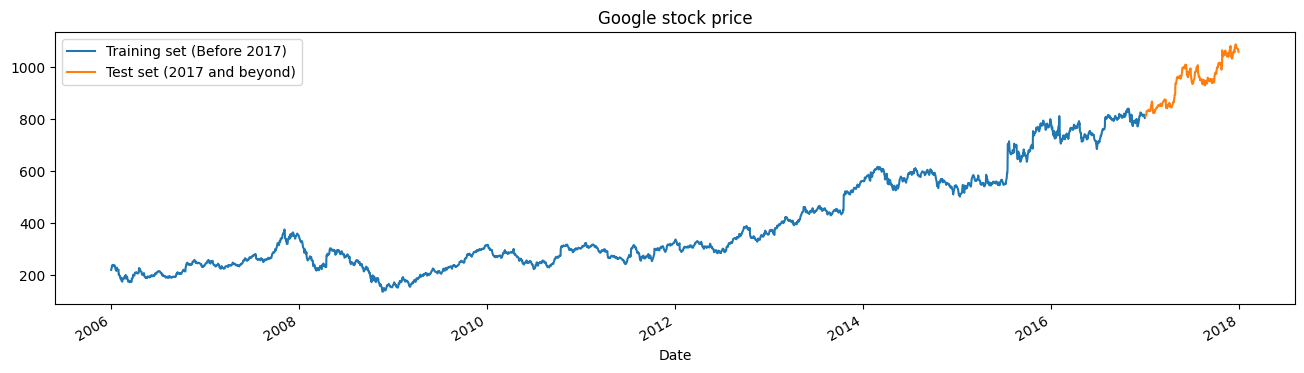

In [21]:
# We have chosen 'High' attribute for prices.
dataset["High"][:'2016-12-31'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017-01-01':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

## Data Preprocessing

Scaling the training set

In [22]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements

In [26]:
X_train = []
y_train = []
for i in range(60, 2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])  # The target should align with the end of the input window

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))


Reshaping X_train for efficient modelling

## LSTM Model

In [28]:
# The LSTM architecture
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 129ms/step - loss: 0.0342
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - loss: 0.0069
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 134ms/step - loss: 0.0048
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - loss: 0.0045
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - loss: 0.0041
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 0.0032
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - loss: 0.0031
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 134ms/step - loss: 0.0030
Epoch 9/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - loss: 0.0030
Epoch 10/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 133ms/step - loss: 0.0025



## Make preductuion with LSTM model

In [29]:
dataset_total = pd.concat((dataset["High"][:'2016-12-31'],dataset["High"]['2017-01-01':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [30]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


Visualizing the results

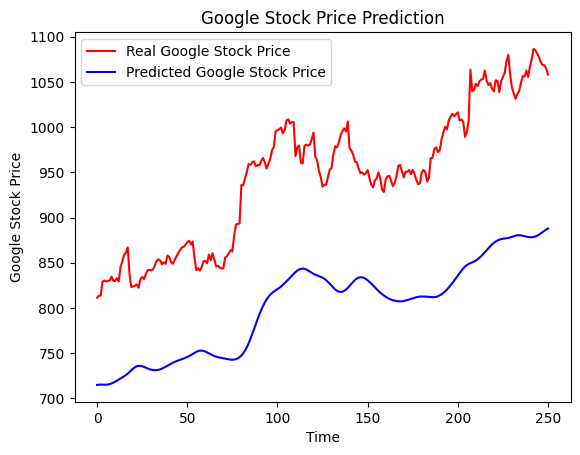

In [31]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

Evaluating LSMT Model

In [32]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 146.8197193324282.


## GRU Model

In [34]:
# The GRU architecture
regressorGRU = Sequential()

# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# The output layer
regressorGRU.add(Dense(units=1))

# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=10,batch_size=150)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - loss: 0.1298
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step - loss: 0.0433
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 279ms/step - loss: 0.0120
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 282ms/step - loss: 0.0036
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 347ms/step - loss: 0.0026
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - loss: 0.0027
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 275ms/step - loss: 0.0023
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.0023
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - loss: 0.0023
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - loss: 0.0024



## Make preductuion with GRU model

In [35]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step


Visualizing the Results

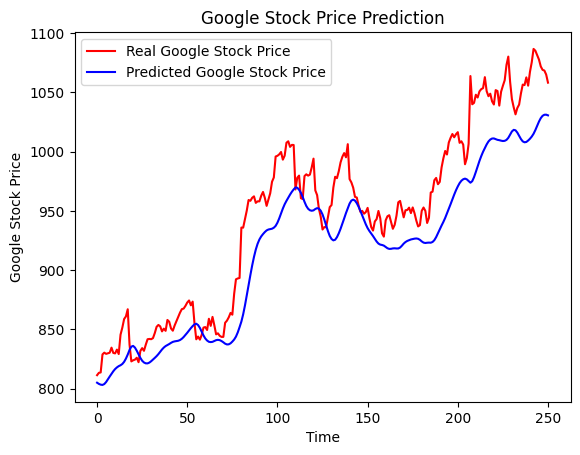

In [36]:
plot_predictions(test_set,GRU_predicted_stock_price)

Evaluating GRU Model

In [37]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 35.224198196945345.
